In [ ]:
# Import libraries and dependencies

In [94]:
# Imort libraries and dependencies
import warnings
warnings.filterwarnings('ignore')
import os
import requests
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
# Initialize the Panel Extensions (for Plotly)
import panel as pn
pn.extension('plotly')
from panel.interact import interact
import plotly.express as px
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline
#import Yfinance
#!pip install yfinance
import yfinance as yf
import datetime as dt
import seaborn as sns

In [3]:
pip install --upgrade mplfinance

Note: you may need to restart the kernel to use updated packages.


In [4]:
import mplfinance as mpf

In [120]:
# Define Parameters

range_of_cryptos = ["BTC-USD", "ETH-USD", "BNB-USD", "ADA-USD", "DOGE-USD", "XRP-USD", "LINK-USD" , "THETA-USD", "LTC-USD", "XLM-USD"]
range_of_stocks = ["AMZN", "TSLA", "NEO", "AAPL", "NVDA", "BABA", "NFLX", "DIS", "NKE"]

# Define Functions

#CALCULATE 1 YEARS BACK DATE
def calc_1years_backdate():
    end = dt.datetime.now().date()
    start = end - dt.timedelta(days=365)
    return start
#CALCULATE 2 YEARS BACK DATE
def calc_2years_backdate():
    end = dt.datetime.now().date()
    start = end - dt.timedelta(days=730)
    return start
#CALCULATE 3 YEARS BACK DATE
def calc_3years_backdate():
    end = dt.datetime.now().date()
    start = end - dt.timedelta(days=1095)
    return start


#download crypto data and stock data for 3 years
def download_cryptos_data():
    df = yf.download(range_of_cryptos, period = "3y", group_by = 'ticker', threads = True, progress=False)
    df = df.dropna().copy()
    return df

def download_stocks_data():
    df = yf.download(range_of_stocks, period = "3y", group_by = 'ticker', threads = True, progress=False)
    df = df.dropna().copy()
    return df




def cumulative_return_plot(df):
    cumulative_returns = (1 + df['Close'].pct_change()).cumprod()
    plot = cumulative_returns.hvplot.line(x="Date", rot=45, shared_axes=False).opts(yformatter="%.0f", width=500, xlabel="Time", ylabel="Value", title="Cumulative Return")
    return plot


def MA_plot(df):
    df["30MA"]=df[["Close"]].rolling(30).mean()
    df["60MA"]=df[["Close"]].rolling(60).mean()
    df["90MA"]=df[["Close"]].rolling(90).mean()
    df.dropna(inplace=True)
    plot = df[["Close", "30MA", "60MA", "90MA"]].hvplot.line(x="Date", rot=45, shared_axes=False).opts(yformatter="%.0f", width=500, xlabel="Date", ylabel="Price", title="Moving Average")
    
    
    return plot


In [121]:
# Create a Title for the Dashboard

# Fetch initial data:
crypto_df = download_cryptos_data()
stock_df = download_stocks_data()
fetch_data_button = pn.widgets.Button(name='FETCH NEW DATA FROM YAHOO FINANCE!', button_type='success')
def update_data(event):
    crypto_df = download_cryptos_data()
    stock_df = download_stocks_data
fetch_data_button.on_click(update_data)



# Define title and welcome text
title = "#Investment Dasboard"
welcome = "This Dashboard provice a visual analysis of historial value for certain stock and cryptos"


#Create Widget Elements:
crypto_ticker = pn.widgets.Select(name='Crypto Tickers', options=range_of_cryptos)
crypto_year_slider = pn.widgets.IntSlider(name='Years of Crypto Data', start=1, end=3, step=1, value=1)
stock_ticker = pn.widgets.Select(name='Stock Tickers', options=range_of_stocks) 
stock_year_slider = pn.widgets.IntSlider(name='Years of Stock Data', start=1, end=3, step=1, value=1)

# Input

#Crypto historical Data:
crypto_input = pn.Column(crypto_ticker, crypto_year_slider, align='center')
@pn.depends(crypto_ticker, crypto_year_slider)
def reactive_crypto_MAchart(crypto_ticker, crypto_year_slider):
    if crypto_year_slider == 1:
        return MA_plot(crypto_df[crypto_ticker].loc[calc_1years_backdate():dt.datetime.now().date()])
    elif crypto_year_slider == 2:
        return MA_plot(crypto_df[crypto_ticker].loc[calc_2years_backdate():dt.datetime.now().date()])
    else:
        return MA_plot(crypto_df[crypto_ticker])
    
@pn.depends(crypto_ticker, crypto_year_slider)
def reactive_crypto_cumulative(crypto_ticker, crypto_year_slider):
    if crypto_year_slider == 1:
        return cumulative_return_plot(crypto_df[crypto_ticker].loc[calc_1years_backdate():dt.datetime.now().date()])
    elif crypto_year_slider == 2:
        return cumulative_return_plot(crypto_df[crypto_ticker].loc[calc_2years_backdate():dt.datetime.now().date()])
    else:
        return cumulative_return_plot(crypto_df[crypto_ticker])
crypto_column = pn.Column(crypto_input, reactive_crypto_MAchart, reactive_crypto_cumulative)


#Stock historical Data:
stock_input = pn.Column(stock_ticker, stock_year_slider, align='center')
@pn.depends(stock_ticker, stock_year_slider)
def reactive_stock_MAchart(stock_ticker, stock_year_slider):
    if stock_year_slider == 1:
        return MA_plot(stock_df[stock_ticker].loc[calc_1years_backdate():dt.datetime.now().date()])
    elif stock_year_slider == 2:
        return MA_plot(stock_df[stock_ticker].loc[calc_2years_backdate():dt.datetime.now().date()])
    else:
        return MA_plot(stock_df[stock_ticker])

@pn.depends(stock_ticker, stock_year_slider)
def reactive_stock_cumulative(stock_ticker, stock_year_slider):
    if stock_year_slider == 1:
        return cumulative_return_plot(stock_df[stock_ticker].loc[calc_1years_backdate():dt.datetime.now().date()])
    elif stock_year_slider == 2:
        return cumulative_return_plot(stock_df[stock_ticker].loc[calc_2years_backdate():dt.datetime.now().date()])
    else:
        return cumulative_return_plot(stock_df[stock_ticker])
stock_column = pn.Column(stock_input, reactive_stock_MAchart, reactive_stock_cumulative)

historical_data_row = pn.Row(crypto_column, stock_column, width=1100)

# Create a layout for the dashboard
dashboard = pn.WidgetBox(pn.Column(title, fetch_data_button,
                        pn.WidgetBox(pn.Tabs(    
                            ("Historical Data", historical_data_row),
                            ("Your Porforlio Alnalysis"),
                            )), align="center"))

In [122]:
dashboard.servable()

WidgetBox
    [0] Column(align='center')
        [0] Markdown(str)
        [1] Button(button_type='success', name='FETCH NEW DATA F...)
        [2] WidgetBox
            [0] Tabs
                [0] Row(width=1100)
                    [0] Column
                        [0] Column(align='center')
                            [0] Select(name='Crypto Tickers', options=['BTC-USD', 'ETH-USD', ...], value='BTC-USD')
                            [1] IntSlider(end=3, name='Years of Crypto Data', start=1, value=1)
                        [1] ParamFunction(function)
                        [2] ParamFunction(function)
                    [1] Column
                        [0] Column(align='center')
                            [0] Select(name='Stock Tickers', options=['AMZN', 'TSLA', ...], value='AMZN')
                            [1] IntSlider(end=3, name='Years of Stock Data', start=1, value=1)
                        [1] ParamFunction(function)
                        [2] ParamFunction(function)
                [1] Markdown(str)

In [5]:
#retreive relevant stocks data

tickers = ['AMZN', 'TSLA', 'NIO', 'AAPL', 'NVDA', 'BABA', 'SPWR', 'NFLX', 'DIS', 'NKE']


#df = yf.download('AMZN')

In [118]:
#CALCULATE 5 YEARS BACK DATE
#download crypto data and stock data for 5 years
def download_cryptos_data(event):
    df = yf.download(range_of_cryptos, period = "5y", group_by = 'ticker', threads = True, progress=False)
    df = df.dropna().copy()
    return df

def download_stocks_data(event):
    df = yf.download(range_of_stocks, period = "5y", group_by = 'ticker', threads = True, progress=False)
    df = df.dropna().copy()
    return df

#CALCULATE 120 days BACK DATE
def calc_120_days_backdate():
    end = dt.datetime.now()
    start = end - dt.timedelta(days=120)
    return start

# CALCULATE Daily Returns
def daily_return_plot(df):
    df = df.dropna().copy()
    plot = df['Close'].pct_change().hvplot.line(x="Date", rot=45).opts(yformatter="%.0f", xlabel="Time", ylabel="Value", title="Daily Return", color="Red")
    return plot

# CALCULATE Cumualative Returns
def cumulative_return_plot(df):
    cumulative_returns = (1 + df['Close'].pct_change()).cumprod()
    plot = cumulative_returns.hvplot.line(x="Date", rot=45).opts(yformatter="%.0f", xlabel="Time", ylabel="Value", title="Cumulative Return", color="Blue")
    return plot

# CALCULATE candle plot"
def candle_volume_plot(df):
    plot = mpf.plot(df,type='candle',mav=(3,6,9),volume=True, title='dissa candle plot', style='starsandstripes')
    
    return plot

[*********************100%***********************]  1 of 1 completed


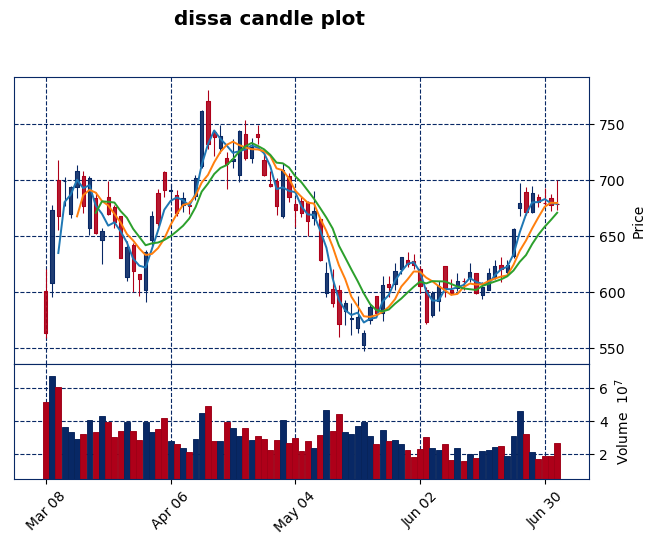

In [119]:
#three_years_ago_date = calc_3years_backdate()
calc_120_days = calc_120_days_backdate()
today = dt.datetime.now()

df =yf.download('TSLA', calc_120_days, today)

candle_volume_plot(df)

In [87]:
(df).head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-03-26,61.467999,61.518002,58.271999,60.835999,60.835999,41876000
2018-03-27,60.799999,60.854000,55.436001,55.835999,55.835999,69360000
2018-03-28,52.916000,53.736000,50.419998,51.556000,51.556000,105007000
2018-03-29,51.298000,54.192001,49.641998,53.226002,53.226002,75853500
2018-04-02,51.251999,52.066002,48.917999,50.495998,50.495998,80570000


In [88]:
df["30MA"]=df[["Close"]].rolling(30).mean()
df["60MA"]=df[["Close"]].rolling(60).mean()
df["90MA"]=df[["Close"]].rolling(90).mean()


df

,Open,High,Low,Close,Adj Close,Volume,30MA,60MA,90MA
Date,,,,,,,,,
2018-03-26,61.467999,61.518002,58.271999,60.835999,60.835999,41876000,NaN,NaN,NaN
2018-03-27,60.799999,60.854000,55.436001,55.835999,55.835999,69360000,NaN,NaN,NaN
2018-03-28,52.916000,53.736000,50.419998,51.556000,51.556000,105007000,NaN,NaN,NaN
2018-03-29,51.298000,54.192001,49.641998,53.226002,53.226002,75853500,NaN,NaN,NaN
2018-04-02,51.251999,52.066002,48.917999,50.495998,50.495998,80570000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-06-28,671.640015,694.700012,670.320007,688.719971,688.719971,21628200,613.464003,650.117668,656.329445
2021-06-29,684.650024,687.510010,675.890015,680.760010,680.760010,17381300,616.928337,649.946168,655.212334
2021-06-30,679.770020,692.809998,678.140015,679.700012,679.700012,18924900,620.322670,649.747502,654.825667


In [89]:
df.dropna(inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume,30MA,60MA,90MA
Date,,,,,,,,,
2018-08-01,59.598000,60.599998,58.599998,60.167999,60.167999,50647000,64.053733,62.647633,61.042600
2018-08-02,65.688004,69.998001,64.632004,69.907997,69.907997,116075000,63.969200,62.806200,61.143400
2018-08-03,69.561996,71.000000,68.505997,69.634003,69.634003,68282500,63.973600,62.943933,61.296711
2018-08-06,69.092003,70.996002,68.363998,68.398003,68.398003,42821500,64.029333,63.067167,61.483845
2018-08-07,68.767998,77.491997,67.830002,75.914001,75.914001,154379000,64.339733,63.328867,61.735933
...,...,...,...,...,...,...,...,...,...
2021-06-28,671.640015,694.700012,670.320007,688.719971,688.719971,21628200,613.464003,650.117668,656.329445
2021-06-29,684.650024,687.510010,675.890015,680.760010,680.760010,17381300,616.928337,649.946168,655.212334
2021-06-30,679.770020,692.809998,678.140015,679.700012,679.700012,18924900,620.322670,649.747502,654.825667


In [117]:
def MA_plot(df):
    df["30MA"]=df[["Close"]].rolling(30).mean()
    df["60MA"]=df[["Close"]].rolling(60).mean()
    df["90MA"]=df[["Close"]].rolling(90).mean()
    df.dropna(inplace=True)
    df[["Close", "30MA", "60MA", "90MA"]].hvplot.line(x="Date", rot=45).opts(yformatter="%.0f", xlabel="Date", ylabel="Price", title="Moving Average")
    
    return MA_plot




:NdOverlay   [Variable]
   :Curve   [Date]   (value)

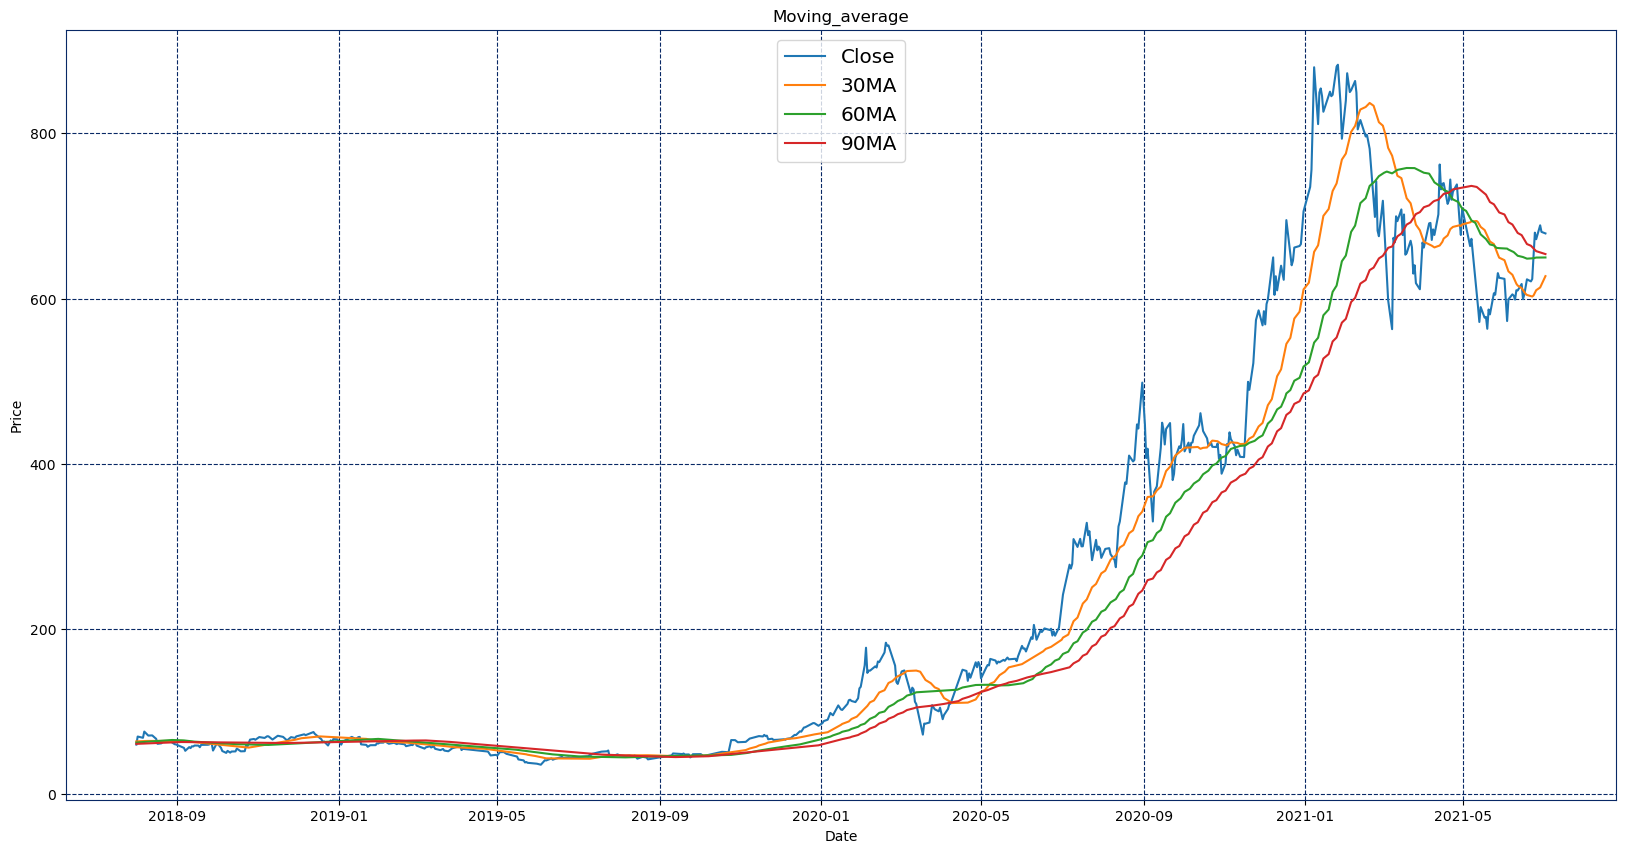

In [91]:
MA_plot()

In [31]:
#create widget
select = pn.widgets.Select(name='Select', options= tickers)

#create function
def create_plot(tickers):
    return df[df['ticker'] == ticker].hvplot('Date', 'Close')

#create interaction between widget and function
interact(create_plot, tickers=select)

KeyError: 'ticker'

In [9]:
ALL = 'ALL'
def unique_sorted_values_plus_ALL(df):
    unique = df.df().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return df


In [28]:
tickers

['AMZN', 'TSLA', 'NIO', 'AAPL', 'NVDA', 'BABA', 'SPWR', 'NFLX', 'DIS', 'NKE']

In [10]:
dropdown = widgets.Dropdown(options = unique_sorted_values_plus_ALL(df))

AttributeError: 'DataFrame' object has no attribute 'df'

In [ ]:
df_london = pd.read_csv("https://data.london.gov.uk/download/number-international-visitors-london/b1e0f953-4c8a-4b45-95f5-e0d143d5641e/international-visitors-london-raw.csv", encoding='latin1')

In [ ]:
ALL = 'ALL'
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique

In [ ]:
dropdown_year = widgets.Dropdown(options = unique_sorted_values_plus_ALL(df_london.year))

def dropdown_year_eventhandler(change):
    if (change.new == ALL):
        display(df_london)
    else:
        display(df_london[df_london.year == change.new])
               
dropdown_year.observe(dropdown_year_eventhandler, names='value')

display(dropdown_year)

In [ ]:
def colour_ge_value(value, comparison):
    if value >= comparison:
        return 'color: red'
    else:
        return 'color: black'

In [ ]:
output = widgets.Output()
plot_output = widgets.Output()

dropdown_year = widgets.Dropdown(options =    unique_sorted_values_plus_ALL(df_london.year), description='Year:')
dropdown_purpose = widgets.Dropdown(options = unique_sorted_values_plus_ALL(df_london.purpose), description='Purpose:')
bounded_num = widgets.BoundedFloatText(min=0, max=100000, value=5, step=1, description='Number:')


def common_filtering(year, purpose, num):
    output.clear_output()
    plot_output.clear_output()
    
    if (year == ALL) & (purpose == ALL):
        common_filter = df_london
    elif (year == ALL):
        common_filter = df_london[df_london.purpose == purpose]
    elif (purpose == ALL):
        common_filter = df_london[df_london.year == year]
    else:
        common_filter = df_london[(df_london.year == year) & 
                                  (df_london.purpose == purpose)]
    
    with output:
        display(common_filter.style.applymap(lambda x: colour_ge_value(x, num), subset=['visits','spend','nights']))
    
    with plot_output:
        sns.kdeplot(common_filter['visits'], shade=True)
        plt.show()
    
def dropdown_year_eventhandler(change):
    common_filtering(change.new, dropdown_purpose.value,bounded_num.value)

def dropdown_purpose_eventhandler(change):
    common_filtering(dropdown_year.value, change.new, bounded_num.value)

def bounded_num_eventhandler(change):
    common_filtering(dropdown_year.value, dropdown_purpose.value, change.new)

dropdown_year.observe(dropdown_year_eventhandler, names='value')
dropdown_purpose.observe(dropdown_purpose_eventhandler, names='value')
bounded_num.observe(bounded_num_eventhandler, names='value')

display(dropdown_year)
display(dropdown_purpose)
display(bounded_num)

In [ ]:

input_widgets = widgets.HBox(
[dropdown_year, dropdown_purpose, bounded_num])
display(input_widgets)



In [ ]:
tab = widgets.Tab([output, plot_output])
tab.set_title(0, 'Dataset Exploration')
tab.set_title(1, 'KDE Plot')
display(tab)

In [ ]:
dashboard = widgets.VBox([input_widgets, tab])
display(dashboard)